## Training the TabNet model

In this notebook, we are going to train the TabNet neural network model, in which the following architectures and tools have been implemented:

- Ghost Batch Normalization
- Sparsemax activation function
- Gated Linear Unit blocks
- Shared and dependant GLU fully connected layers across all decision steps
- Attentive Transformer
- Feature Transformer

The architecture of the TabNet model is described in the following paper: https://arxiv.org/pdf/1908.07442.pdf.

The implementation of all building blocks of the model can be found in the file: <i>TabNetBlocks.py</i> in this repository.

Pytorch Datasets are defined in the following file: <i>PytorchDatasets.py</i>

Let's start with importing all indispensable libraries.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from TabNetBlocks import TabNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import h5py
import mariadb
import matplotlib.pyplot as plt
import seaborn as sns
from getpass import getpass
from PytorchDatasets import DatasetFromHDF5, PandasDataset, MariaDB_chunk_indices, MariaDB_dataset
from config import mariadb_hostname, mariadb_database_name, mariadb_port, mariadb_table_name

We also have to load the normalization parameters.

In [2]:
with open(r"norm_params.pickle", "rb") as output_file:
    norm_params = pickle.load(output_file)

Now we will connect to the MariaDB server.

In [3]:
print('Login to MariaDB:')
mariadb_user = input('User: ')
mariadb_password = getpass('Password: ')

# Connect to MariaDB server
try:
    cnx = mariadb.connect(host=mariadb_hostname, port=mariadb_port, user=mariadb_user, password=mariadb_password)
except mariadb.Error as msg:
    logging.error("Error connecting to MariaDB Platform: {}".format(msg))
    sys.exit(1)

# Instantiate cursor object
cursor = cnx.cursor()

# Use given database
cursor.execute("USE {};".format(mariadb_database_name))

Login to MariaDB:
User: root
Password: ········


We will use the Pytorch MariaDB Dataset class to load the data in a chunked manner. At first, we will generate the chunks indices that will be provided into the loader. To do this we will utilize the <i>MariaDB_chunk_indices</i> class from the <i>PytorchDatasets.py file</i>.

In [4]:
# Parameters: cursor, table_name, chunk_size
chunk_indices = MariaDB_chunk_indices(cursor, mariadb_table_name, 1024 * 50)

Subsequently, we will continuously read rows specified by the indices parameter from the MariaDB database.

To load only particular input features, provide them under the <i>feat_cols</i> variable (list of input column names).

In [5]:
feat_cols = None

for chunk_ind in chunk_indices:
    
    mariadb_dataset = MariaDB_dataset(chunk_ind, cursor, mariadb_table_name, norm_params, feat_cols=feat_cols)
    
    batch_loader = DataLoader(mariadb_dataset, batch_size=2, drop_last=True)
    
    for input_feat, target in batch_loader:
        print('Input feat: ', input_feat)
        print('target: ', target)
        
        break
    break

Input feat:  tensor([[8.4529e-02, 1.6240e-04, 4.1961e-01, 1.6239e-04, 4.1176e-01, 1.6282e-04,
         6.6667e-01, 1.6284e-04, 2.4314e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 7.8333e-01, 5.1944e-01, 6.4251e-02, 7.8333e-01, 5.1944e-01,
         1.1065e-02, 7.8333e-01, 5.1944e-01, 1.0792e-02, 7.8333e-01, 5.1667e-01,
         7.6991e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 4.6947e-01, 4.6207e-01, 5.0287e-01, 4.9535e-01, 5.3608e-01,
         5.2707e-01, 7.8438e-01, 5.1848e-01, 7.8438e-01, 5.1848e-01],
        [8.1506e-01, 3.3662e-03, 7.2941e-01, 3.3661e-03, 7.8431e-02, 3.3665e-03,
         7.4510e-02, 3.3666e-03, 3.9216e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 7.9444e-01, 5.1944e-01, 7.6223e-03, 7.9444e-01, 5.1667e-01,
         9.8353e-04, 7.9444e-01, 5.1667e-01, 1.2291e-03, 7.9444e-01, 5.1389e-01,
         1.4749e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 4.302

Now is the time to create the evaluation and test datasets. To limit the size of these sets we will load 3 million rows from the CSV, and then take a random sample from it.

In [6]:
eval_test_df = pd.read_csv('round2_competition_data/eval_test/eval_test.csv', nrows=3e+6)

In [7]:
# Take a random sample of eval_test dataframe
eval_test_df = eval_test_df.sample(n=800000)

Below we will split the dataset into the evaluation and test sets.

In [8]:
# Split dataframe to evaluation and test sets
eval_df, test_df = train_test_split(eval_test_df, test_size=0.4)

In [9]:
# feat_cols = norm_params['input_features'][:30]
feat_cols = None
eval_set = PandasDataset(eval_test_df, norm_params, feat_cols=feat_cols)
# test_set = PandasDataset(test_df, norm_params)

In [10]:
eval_loader = DataLoader(eval_set, batch_size=2, shuffle=False, drop_last=True)
# test_loader = DataLoader(test_set, batch_size=2, shuffle=False, drop_last=False)

Let's look at how the data in the evaluation set present.

In [11]:
for input_feat, target in eval_loader:
    print('input_feat:', input_feat)
    print('target:', target)
    break

input_feat: tensor([[ 4.0113e-01,  2.1952e-01,  7.2157e-01,  2.3402e-01,  7.2549e-01,
          2.1952e-01,  2.7843e-01,  2.1952e-01,  7.5294e-01,  2.2275e-01,
          3.4902e-01,  2.4431e-01,  5.2549e-01,  7.9468e-01,  4.9381e-01,
          4.8930e-02,  7.9572e-01,  4.9750e-01,  1.5491e-02,  7.9723e-01,
          4.9359e-01,  2.0895e-02,  7.9762e-01,  4.9150e-01,  4.9164e-03,
          7.9690e-01,  4.9177e-01,  1.1259e-02,  7.9762e-01,  4.9150e-01,
          3.6873e-03,  2.0403e+04,  5.7852e-01, -2.0292e+04,  1.0799e+00,
         -2.0145e+04,  9.9250e-01,  7.9663e-01,  4.9328e-01,  7.9664e-01,
          4.9323e-01],
        [ 5.7070e-01,  2.4573e-02,  2.5098e-01,  2.7955e-02,  2.1961e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  7.2309e-01,  5.2393e-01,
          2.2612e-02,  7.3253e-01,  5.3507e-01,  3.3159e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
   

Below we will define a function that inverses the normalization and converts WSG84 coordinates to cartesian ones. This function will be used as a helper function while calculating the distance error in kilometres.

In [12]:
# Target's normalization parameters
y_min = np.array([norm_params[col]['min'] for col in norm_params['target']])
y_max = np.array([norm_params[col]['max'] for col in norm_params['target']])

def lla_to_ecef(df):
    """Reverses the normalization and converts WSG84 coordinates to cartesian ones.
    
    """
    
    # Inverse the normalization
    df = df * (y_max - y_min) + y_min
    
    latitude = np.radians(df[:, 0])
    longitude = np.radians(df[:, 1])
    altitude = df[:, 2]

    # WSG84 ellipsoid constants
    a = 6378137
    e = 8.1819190842622e-2

    # Prime vertical radius of curvature
    N = a / np.sqrt(1 - e**2 * np.sin(latitude)**2)
    
    x = (N + altitude) * np.cos(latitude) * np.cos(longitude)
    y = (N + altitude) * np.cos(latitude) * np.sin(longitude)
    z = ((1 - e**2) * N + altitude) * np.sin(latitude)

    # df = torch.cat([x.unsqueeze(1), y.unsqueeze(1), z.unsqueeze(1)], dim=1)

    df = np.hstack([np.expand_dims(x, axis=1), np.expand_dims(y, axis=1), np.expand_dims(z, axis=1)])
    
    return df

Subsequently, we will define functions that will perform a single training or evaluation epoch. Those functions will take as an argument the Pytorch TabNet model and training/evaluation iterator, and return the metrics such as average loss, mean distance error or explanatory mask.

In [13]:
def train_model(model, train_iterator):
    """Perform single training epoch.

    Parameters
    ----------
    model: TabNet class object
    train_iterator: torch.utils.data.DataLoader
        Pytorch DataLoader object that loads data from MariaDB_dataset/PandasDataset/DatasetFromHDF5

    Returns
    -------
    train_losses: list
        List of the average training batch losses
    avg_loss: float
        Average loss on the entire training set (1 epoch)
    mean_dist_error: float
        Mean distance error in kilometres
    mask_list: list
        List of masks.
    mask_explain_list: list
        List of explanatory masks
    
    """
    
    model.train()
    model.double()        

    train_losses = []
    losses = []
    dist_errors_list = []
    pred_total = torch.DoubleTensor()
    target_total = torch.DoubleTensor()

    for i, batch in enumerate(train_iterator, 1):

        input_feat, target = batch
        
        mask_list = []
        mask_explain_list = []

        input_feat.to(model.device)
        target.to(model.device)

        model.optimizer.zero_grad()

        pred, sparse_loss, masks, mask_explain = model.forward(input_feat)
        loss = model.loss_fn(pred, target)
        loss -= 1e-3 * sparse_loss.squeeze(-1)
        loss.backward()
        losses.append(loss.data.cpu().numpy())
        
        model.optimizer.step()
     
        pred_total = torch.cat([pred_total, pred], dim=0)
        target_total = torch.cat([target_total, target], dim=0)
        
        print_every = len(train_iterator) // 2
        
        if i % print_every == 0:
            avg_train_loss = np.mean(losses)
            train_losses.append(avg_train_loss)

            pred_ecef = lla_to_ecef(pred_total.detach().numpy())
            target_ecef = lla_to_ecef(target_total.detach().numpy())

            # Calculate the average prediciton - target distance error in kilometers
            dist_error = np.sqrt((pred_ecef[:, 0] - target_ecef[:, 0])**2 + (pred_ecef[:, 1] - target_ecef[:, 1])**2 + \
                    (pred_ecef[:, 2] - target_ecef[:, 2])**2) / 1000

            dist_error = np.mean(np.abs(dist_error))
            dist_errors_list.append(dist_error)

            print('Average training loss: {:.4f}. Mean distance error (km): {:.3f}'\
                  .format(avg_train_loss, dist_error))

            losses = []

            pred_total = torch.DoubleTensor()
            target_total = torch.DoubleTensor()
            
            mask_list.append(masks)
            mask_explain_list.append(mask_explain)

    avg_loss = np.mean(train_losses)

    mean_dist_error = np.mean(dist_errors_list)

    return train_losses, avg_loss, mean_dist_error, mask_list, mask_explain_list


def evaluate_model(model, eval_iterator):
    """Perform single evaluation epoch.

    Parameters
    ----------
    model: TabNet class object
    eval_iterator: torch.utils.data.DataLoader
        Pytorch DataLoader object that loads data from MariaDB_dataset/PandasDataset/DatasetFromHDF5

    Returns
    -------
    eval_losses: list
        List of the average evaluation batch losses
    avg_loss: float
        Average loss on the entire training set (1 epoch)
    mean_dist_error: float
        Mean distance error in kilometres
    
    """
    
    model.eval()
    model.double() 

    eval_losses = []
    losses = []
    dist_errors_list = []
    pred_total = torch.DoubleTensor()
    target_total = torch.DoubleTensor()

    with torch.no_grad():
        for i, batch in tqdm(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):

            input_feat, target = batch

            input_feat.to(model.device)
            target.to(model.device)
            
            pred, sparse_loss, _, _ = model.forward(input_feat)
            loss = model.loss_fn(pred, target)
            loss -= 1e-3 * sparse_loss.squeeze(-1)
            losses.append(loss.data.cpu().numpy())
            
            pred_total = torch.cat([pred_total, pred], dim=0)
            target_total = torch.cat([target_total, target], dim=0)     
            
            print_every = len(eval_iterator) // 2

            if i % print_every == 0:
                avg_eval_loss = np.mean(losses)
                eval_losses.append(avg_eval_loss)

                pred_ecef = lla_to_ecef(pred_total.detach().numpy())
                target_ecef = lla_to_ecef(target_total.detach().numpy())

                # Calculate the average prediciton - target distance error in kilometers
                dist_error = np.sqrt((pred_ecef[:, 0] - target_ecef[:, 0])**2 + (pred_ecef[:, 1] - target_ecef[:, 1])**2 + \
                        (pred_ecef[:, 2] - target_ecef[:, 2])**2) / 1000

                dist_error = np.mean(np.abs(dist_error))
                dist_errors_list.append(dist_error)

                print('Iteration: {}. Average evaluation loss: {:.4f}. Mean distance error (km): {:.3f}'\
                      .format(i, avg_eval_loss, dist_error))

                losses = []

                pred_total = torch.DoubleTensor()
                target_total = torch.DoubleTensor()

    avg_loss = np.mean(eval_losses)

    mean_dist_error = np.mean(dist_errors_list)

    return eval_losses, avg_loss, mean_dist_error

Below we will set the parameters of the model. Note that I decided to train a not too complex model, but you can still play with those parameters to fine-tune a more sophisticated neural network. Then we will instantiate the model, add loss function, optimizer, and device to it and begin the training. We will also define a scheduler object that will be responsible for adjusting the learning rate based on the number of epochs.

In [14]:
# Initialize parameters
input_dim = eval_set.n_features
output_dim = 3
n_d = 32
n_a = 32
gamma = 1.2
epsilon = 1e-10
n_shared = 3
n_independent = 3
n_steps = 3
n_chunks = 64
chunk_size = 0
track_running_stats = False
momentum = 0.02
learning_rate = 0.007
epochs = 8
batch_size = 6144
feat_cols = None
ghost_batch_norm = True

train_iterator = MariaDB_chunk_indices(cursor, mariadb_table_name, 1024 * 1000)

eval_loader = DataLoader(eval_set, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = TabNet(input_dim, output_dim, n_d, n_a, gamma=gamma, epsilon=epsilon, n_shared=n_shared, n_independent=n_independent,
               n_steps=n_steps, n_chunks=n_chunks, chunk_size=chunk_size, track_running_stats=track_running_stats,
               momentum=momentum, ghost_batch_norm=ghost_batch_norm)

# Move the model to GPU if possible
# if CUDA:
#     model.cuda()

model.add_loss_fn(nn.MSELoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

# device = torch.device('cuda' if CUDA else 'cpu')
device = torch.device('cpu')

model.add_device(device)

train_losses_list, train_avg_loss_list, train_dist_list = [], [], []
eval_avg_loss_list, eval_dist_list = [], []
train_mask_list, train_mask_explain_list = [], []

for epoch in range(epochs):

    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    print('Current learning rate: {:.5f}'.format(scheduler.get_last_lr()[0]))
    
    for indices in tqdm(train_iterator):
        
        train_loader = DataLoader(MariaDB_dataset(indices, cursor, mariadb_table_name, norm_params, feat_cols=feat_cols),
                                  batch_size=batch_size, shuffle=True, drop_last=True)
        
        train_losses, train_avg_loss, train_dist, mask_list, mask_explain_list = train_model(model, train_loader)

    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_dist_list.append(train_dist)
    train_mask_list.append(mask_list)
    train_mask_explain_list.append(mask_explain_list)

    _, eval_avg_loss, eval_dist = evaluate_model(model, eval_loader)

    eval_avg_loss_list.append(eval_avg_loss)
    eval_dist_list.append(eval_dist)

    print('\nEpoch [{}/{}]: Train distance error (km): {:.3f}. Train loss: {:.4f}. Evaluation distance error (km): {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_dist, train_avg_loss, eval_dist, eval_avg_loss))
    
    scheduler.step()
   

  0%|                                                                                           | 0/19 [00:00<?, ?it/s]


Start epoch [1/8]
Current learning rate: 0.00700
Average training loss: 0.0376. Mean distance error (km): 2911.726


  5%|████▏                                                                           | 1/19 [05:01<1:30:20, 301.14s/it]

Average training loss: 0.0174. Mean distance error (km): 1073.341
Average training loss: 0.0163. Mean distance error (km): 862.944
Average training loss: 0.0129. Mean distance error (km): 884.390


 11%|████████▍                                                                       | 2/19 [09:55<1:24:45, 299.17s/it]

Average training loss: 0.0063. Mean distance error (km): 771.523


 16%|████████████▋                                                                   | 3/19 [14:55<1:19:47, 299.23s/it]

Average training loss: 0.0056. Mean distance error (km): 783.126
Average training loss: 0.0036. Mean distance error (km): 685.874
Average training loss: 0.0024. Mean distance error (km): 555.967


 21%|████████████████▊                                                               | 4/19 [19:50<1:14:29, 297.98s/it]

Average training loss: 0.0035. Mean distance error (km): 718.883


 26%|█████████████████████                                                           | 5/19 [24:50<1:09:40, 298.64s/it]

Average training loss: 0.0027. Mean distance error (km): 560.405
Average training loss: 0.0027. Mean distance error (km): 527.124
Average training loss: 0.0024. Mean distance error (km): 503.026


 32%|█████████████████████████▎                                                      | 6/19 [29:38<1:03:59, 295.36s/it]

Average training loss: 0.0025. Mean distance error (km): 482.787


 37%|██████████████████████████████▏                                                   | 7/19 [34:29<58:51, 294.29s/it]

Average training loss: 0.0026. Mean distance error (km): 602.369
Average training loss: 0.0016. Mean distance error (km): 542.421
Average training loss: 0.0016. Mean distance error (km): 508.655


 42%|██████████████████████████████████▌                                               | 8/19 [39:07<53:03, 289.43s/it]

Average training loss: 0.0015. Mean distance error (km): 498.913


 47%|██████████████████████████████████████▊                                           | 9/19 [43:37<47:13, 283.37s/it]

Average training loss: 0.0013. Mean distance error (km): 493.110
Average training loss: 0.0011. Mean distance error (km): 486.107
Average training loss: 0.0008. Mean distance error (km): 486.586


 53%|██████████████████████████████████████████▋                                      | 10/19 [48:05<41:51, 279.02s/it]

Average training loss: 0.0008. Mean distance error (km): 480.760


 58%|██████████████████████████████████████████████▉                                  | 11/19 [53:10<38:12, 286.57s/it]

Average training loss: 0.0010. Mean distance error (km): 486.434
Average training loss: 0.0011. Mean distance error (km): 465.807


 63%|███████████████████████████████████████████████████▏                             | 12/19 [58:02<33:38, 288.40s/it]

Average training loss: 0.0010. Mean distance error (km): 456.934
Average training loss: 0.0011. Mean distance error (km): 508.564
Average training loss: 0.0010. Mean distance error (km): 530.967


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:03:17<29:38, 296.42s/it]

Average training loss: 0.0009. Mean distance error (km): 497.309


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:08:29<25:04, 300.91s/it]

Average training loss: 0.0008. Mean distance error (km): 484.887
Average training loss: 0.0008. Mean distance error (km): 491.257
Average training loss: 0.0007. Mean distance error (km): 476.943


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:13:22<19:54, 298.72s/it]

Average training loss: 0.0007. Mean distance error (km): 472.377


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:18:24<14:58, 299.65s/it]

Average training loss: 0.0010. Mean distance error (km): 492.963
Average training loss: 0.0008. Mean distance error (km): 506.223
Average training loss: 0.0008. Mean distance error (km): 505.855


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:23:29<10:02, 301.03s/it]

Average training loss: 0.0007. Mean distance error (km): 496.310


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:28:46<05:05, 305.98s/it]

Average training loss: 0.0006. Mean distance error (km): 501.225
Average training loss: 0.0008. Mean distance error (km): 496.275


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0007. Mean distance error (km): 482.878


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:20<01:14,  1.14s/it]

Iteration: 65. Average evaluation loss: 0.0182. Mean distance error (km): 723.815


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Iteration: 130. Average evaluation loss: 0.0183. Mean distance error (km): 726.390

Epoch [1/8]: Train distance error (km): 489.576. Train loss: 0.0008. Evaluation distance error (km): 725.102. Evaluation loss: 0.0182

Start epoch [2/8]
Current learning rate: 0.00490
Average training loss: 0.0007. Mean distance error (km): 482.008


  5%|████▏                                                                           | 1/19 [05:02<1:30:49, 302.76s/it]

Average training loss: 0.0007. Mean distance error (km): 478.413
Average training loss: 0.0007. Mean distance error (km): 475.081
Average training loss: 0.0005. Mean distance error (km): 473.678


 11%|████████▍                                                                       | 2/19 [09:59<1:25:18, 301.09s/it]

Average training loss: 0.0006. Mean distance error (km): 478.480


 16%|████████████▋                                                                   | 3/19 [14:59<1:20:10, 300.67s/it]

Average training loss: 0.0007. Mean distance error (km): 469.121
Average training loss: 0.0007. Mean distance error (km): 470.407
Average training loss: 0.0007. Mean distance error (km): 478.342


 21%|████████████████▊                                                               | 4/19 [19:58<1:15:02, 300.18s/it]

Average training loss: 0.0006. Mean distance error (km): 465.003


 26%|█████████████████████                                                           | 5/19 [24:43<1:08:58, 295.63s/it]

Average training loss: 0.0005. Mean distance error (km): 472.215
Average training loss: 0.0006. Mean distance error (km): 467.212
Average training loss: 0.0005. Mean distance error (km): 466.108


 32%|█████████████████████████▎                                                      | 6/19 [29:29<1:03:23, 292.57s/it]

Average training loss: 0.0006. Mean distance error (km): 464.738


 37%|██████████████████████████████▏                                                   | 7/19 [34:43<59:48, 299.00s/it]

Average training loss: 0.0005. Mean distance error (km): 467.135
Average training loss: 0.0005. Mean distance error (km): 460.887
Average training loss: 0.0005. Mean distance error (km): 460.367


 42%|██████████████████████████████████▌                                               | 8/19 [40:02<55:55, 305.08s/it]

Average training loss: 0.0005. Mean distance error (km): 461.228


 47%|██████████████████████████████████████▊                                           | 9/19 [45:14<51:11, 307.15s/it]

Average training loss: 0.0005. Mean distance error (km): 459.622
Average training loss: 0.0005. Mean distance error (km): 463.985
Average training loss: 0.0005. Mean distance error (km): 465.190


 53%|██████████████████████████████████████████▋                                      | 10/19 [50:49<47:19, 315.45s/it]

Average training loss: 0.0005. Mean distance error (km): 460.087


 58%|██████████████████████████████████████████████▉                                  | 11/19 [56:26<42:55, 321.89s/it]

Average training loss: 0.0004. Mean distance error (km): 458.620
Average training loss: 0.0004. Mean distance error (km): 460.138


 63%|█████████████████████████████████████████████████▉                             | 12/19 [1:01:28<36:51, 315.96s/it]

Average training loss: 0.0004. Mean distance error (km): 458.175
Average training loss: 0.0004. Mean distance error (km): 456.381
Average training loss: 0.0004. Mean distance error (km): 451.279


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:06:26<31:03, 310.63s/it]

Average training loss: 0.0007. Mean distance error (km): 464.890


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:11:35<25:50, 310.11s/it]

Average training loss: 0.0006. Mean distance error (km): 451.709
Average training loss: 0.0007. Mean distance error (km): 455.052
Average training loss: 0.0006. Mean distance error (km): 460.033


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:16:44<20:39, 309.97s/it]

Average training loss: 0.0006. Mean distance error (km): 447.939


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:21:58<15:33, 311.16s/it]

Average training loss: 0.0005. Mean distance error (km): 452.357
Average training loss: 0.0005. Mean distance error (km): 445.118
Average training loss: 0.0005. Mean distance error (km): 443.197


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:27:11<10:23, 311.64s/it]

Average training loss: 0.0005. Mean distance error (km): 442.439


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:32:23<05:11, 311.67s/it]

Average training loss: 0.0005. Mean distance error (km): 447.608
Average training loss: 0.0004. Mean distance error (km): 450.952


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0004. Mean distance error (km): 449.193


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:12<01:15,  1.16s/it]

Iteration: 65. Average evaluation loss: 0.0061. Mean distance error (km): 738.533


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Iteration: 130. Average evaluation loss: 0.0061. Mean distance error (km): 737.688

Epoch [2/8]: Train distance error (km): 450.072. Train loss: 0.0004. Evaluation distance error (km): 738.111. Evaluation loss: 0.0061

Start epoch [3/8]
Current learning rate: 0.00343
Average training loss: 0.0004. Mean distance error (km): 445.400


  5%|████▏                                                                           | 1/19 [05:01<1:30:26, 301.49s/it]

Average training loss: 0.0004. Mean distance error (km): 454.910
Average training loss: 0.0004. Mean distance error (km): 454.661
Average training loss: 0.0003. Mean distance error (km): 448.194


 11%|████████▍                                                                       | 2/19 [10:43<1:28:53, 313.74s/it]

Average training loss: 0.0003. Mean distance error (km): 447.482


 16%|████████████▋                                                                   | 3/19 [16:31<1:26:22, 323.92s/it]

Average training loss: 0.0003. Mean distance error (km): 440.622
Average training loss: 0.0003. Mean distance error (km): 435.640
Average training loss: 0.0003. Mean distance error (km): 435.459


 21%|████████████████▊                                                               | 4/19 [21:53<1:20:50, 323.36s/it]

Average training loss: 0.0003. Mean distance error (km): 437.390


 26%|█████████████████████                                                           | 5/19 [27:05<1:14:38, 319.92s/it]

Average training loss: 0.0003. Mean distance error (km): 432.056
Average training loss: 0.0003. Mean distance error (km): 433.175
Average training loss: 0.0003. Mean distance error (km): 429.800


 32%|█████████████████████████▎                                                      | 6/19 [32:55<1:11:14, 328.84s/it]

Average training loss: 0.0003. Mean distance error (km): 425.984


 37%|█████████████████████████████▍                                                  | 7/19 [38:14<1:05:12, 326.02s/it]

Average training loss: 0.0003. Mean distance error (km): 420.961
Average training loss: 0.0003. Mean distance error (km): 420.993
Average training loss: 0.0003. Mean distance error (km): 419.188


 42%|██████████████████████████████████▌                                               | 8/19 [43:27<59:02, 322.06s/it]

Average training loss: 0.0003. Mean distance error (km): 426.652


 47%|██████████████████████████████████████▊                                           | 9/19 [48:57<54:05, 324.57s/it]

Average training loss: 0.0003. Mean distance error (km): 416.627
Average training loss: 0.0003. Mean distance error (km): 421.161
Average training loss: 0.0003. Mean distance error (km): 414.333


 53%|██████████████████████████████████████████▋                                      | 10/19 [54:12<48:14, 321.60s/it]

Average training loss: 0.0003. Mean distance error (km): 417.749


 58%|██████████████████████████████████████████████▉                                  | 11/19 [59:25<42:31, 318.99s/it]

Average training loss: 0.0003. Mean distance error (km): 411.957
Average training loss: 0.0003. Mean distance error (km): 411.826


 63%|█████████████████████████████████████████████████▉                             | 12/19 [1:04:28<36:38, 314.12s/it]

Average training loss: 0.0003. Mean distance error (km): 412.339
Average training loss: 0.0003. Mean distance error (km): 408.730
Average training loss: 0.0003. Mean distance error (km): 408.301


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:09:28<31:00, 310.05s/it]

Average training loss: 0.0003. Mean distance error (km): 409.824


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:14:28<25:34, 306.93s/it]

Average training loss: 0.0003. Mean distance error (km): 407.228
Average training loss: 0.0003. Mean distance error (km): 407.507
Average training loss: 0.0003. Mean distance error (km): 405.422


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:19:40<20:34, 308.57s/it]

Average training loss: 0.0003. Mean distance error (km): 412.966


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:24:44<15:21, 307.14s/it]

Average training loss: 0.0003. Mean distance error (km): 406.693
Average training loss: 0.0003. Mean distance error (km): 409.699
Average training loss: 0.0003. Mean distance error (km): 402.010


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:29:52<10:14, 307.34s/it]

Average training loss: 0.0003. Mean distance error (km): 403.465


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:34:58<05:07, 307.07s/it]

Average training loss: 0.0003. Mean distance error (km): 401.325
Average training loss: 0.0003. Mean distance error (km): 396.461


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0003. Mean distance error (km): 399.310


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:14<01:16,  1.18s/it]

Iteration: 65. Average evaluation loss: 0.0017. Mean distance error (km): 725.490


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Iteration: 130. Average evaluation loss: 0.0017. Mean distance error (km): 727.854

Epoch [3/8]: Train distance error (km): 397.886. Train loss: 0.0003. Evaluation distance error (km): 726.672. Evaluation loss: 0.0017

Start epoch [4/8]
Current learning rate: 0.00240
Average training loss: 0.0002. Mean distance error (km): 396.306


  5%|████▏                                                                           | 1/19 [05:01<1:30:22, 301.27s/it]

Average training loss: 0.0002. Mean distance error (km): 394.759
Average training loss: 0.0003. Mean distance error (km): 394.784
Average training loss: 0.0002. Mean distance error (km): 392.998


 11%|████████▍                                                                       | 2/19 [10:17<1:26:37, 305.71s/it]

Average training loss: 0.0003. Mean distance error (km): 395.387


 16%|████████████▋                                                                   | 3/19 [15:15<1:20:53, 303.37s/it]

Average training loss: 0.0002. Mean distance error (km): 393.788
Average training loss: 0.0003. Mean distance error (km): 392.090
Average training loss: 0.0002. Mean distance error (km): 391.349


 21%|████████████████▊                                                               | 4/19 [20:02<1:14:36, 298.45s/it]

Average training loss: 0.0002. Mean distance error (km): 391.356


 26%|█████████████████████                                                           | 5/19 [24:50<1:08:54, 295.32s/it]

Average training loss: 0.0002. Mean distance error (km): 391.105
Average training loss: 0.0002. Mean distance error (km): 387.065
Average training loss: 0.0002. Mean distance error (km): 388.017


 32%|█████████████████████████▎                                                      | 6/19 [29:35<1:03:21, 292.40s/it]

Average training loss: 0.0002. Mean distance error (km): 391.787


 37%|██████████████████████████████▏                                                   | 7/19 [34:25<58:18, 291.51s/it]

Average training loss: 0.0002. Mean distance error (km): 386.867
Average training loss: 0.0002. Mean distance error (km): 388.706
Average training loss: 0.0002. Mean distance error (km): 387.457


 42%|██████████████████████████████████▌                                               | 8/19 [39:11<53:09, 289.98s/it]

Average training loss: 0.0002. Mean distance error (km): 385.153


 47%|██████████████████████████████████████▊                                           | 9/19 [43:56<48:04, 288.44s/it]

Average training loss: 0.0002. Mean distance error (km): 385.876
Average training loss: 0.0002. Mean distance error (km): 385.599
Average training loss: 0.0003. Mean distance error (km): 388.350


 53%|██████████████████████████████████████████▋                                      | 10/19 [48:41<43:06, 287.42s/it]

Average training loss: 0.0002. Mean distance error (km): 386.991


 58%|██████████████████████████████████████████████▉                                  | 11/19 [53:26<38:13, 286.66s/it]

Average training loss: 0.0002. Mean distance error (km): 384.654
Average training loss: 0.0002. Mean distance error (km): 384.748


 63%|███████████████████████████████████████████████████▏                             | 12/19 [58:15<33:31, 287.42s/it]

Average training loss: 0.0002. Mean distance error (km): 386.874
Average training loss: 0.0002. Mean distance error (km): 384.640
Average training loss: 0.0003. Mean distance error (km): 386.349


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:03:02<28:44, 287.36s/it]

Average training loss: 0.0002. Mean distance error (km): 384.821


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:07:49<23:56, 287.22s/it]

Average training loss: 0.0002. Mean distance error (km): 385.151
Average training loss: 0.0002. Mean distance error (km): 387.294
Average training loss: 0.0002. Mean distance error (km): 383.614


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:12:52<19:27, 291.85s/it]

Average training loss: 0.0002. Mean distance error (km): 384.915


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:18:02<14:52, 297.45s/it]

Average training loss: 0.0002. Mean distance error (km): 381.610
Average training loss: 0.0002. Mean distance error (km): 381.600
Average training loss: 0.0002. Mean distance error (km): 381.342


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:23:17<10:05, 302.58s/it]

Average training loss: 0.0002. Mean distance error (km): 381.249


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:28:41<05:08, 308.88s/it]

Average training loss: 0.0002. Mean distance error (km): 380.077
Average training loss: 0.0002. Mean distance error (km): 380.114


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0002. Mean distance error (km): 380.157


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:11<01:13,  1.14s/it]

Iteration: 65. Average evaluation loss: 0.0017. Mean distance error (km): 719.824


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Iteration: 130. Average evaluation loss: 0.0016. Mean distance error (km): 720.913

Epoch [4/8]: Train distance error (km): 380.135. Train loss: 0.0002. Evaluation distance error (km): 720.369. Evaluation loss: 0.0016

Start epoch [5/8]
Current learning rate: 0.00168
Average training loss: 0.0002. Mean distance error (km): 377.869


  5%|████▏                                                                           | 1/19 [05:15<1:34:46, 315.91s/it]

Average training loss: 0.0002. Mean distance error (km): 377.854
Average training loss: 0.0002. Mean distance error (km): 378.337
Average training loss: 0.0002. Mean distance error (km): 376.622


 11%|████████▍                                                                       | 2/19 [10:40<1:30:14, 318.49s/it]

Average training loss: 0.0002. Mean distance error (km): 377.527


 16%|████████████▋                                                                   | 3/19 [16:18<1:26:28, 324.29s/it]

Average training loss: 0.0002. Mean distance error (km): 375.485
Average training loss: 0.0002. Mean distance error (km): 378.764
Average training loss: 0.0002. Mean distance error (km): 376.911


 21%|████████████████▊                                                               | 4/19 [21:41<1:21:01, 324.12s/it]

Average training loss: 0.0002. Mean distance error (km): 376.021


 26%|█████████████████████                                                           | 5/19 [27:43<1:18:15, 335.40s/it]

Average training loss: 0.0002. Mean distance error (km): 375.472
Average training loss: 0.0002. Mean distance error (km): 373.145
Average training loss: 0.0002. Mean distance error (km): 376.033


 32%|█████████████████████████▎                                                      | 6/19 [33:01<1:11:30, 330.03s/it]

Average training loss: 0.0002. Mean distance error (km): 374.644


 37%|█████████████████████████████▍                                                  | 7/19 [38:05<1:04:29, 322.44s/it]

Average training loss: 0.0002. Mean distance error (km): 376.727
Average training loss: 0.0002. Mean distance error (km): 372.139
Average training loss: 0.0002. Mean distance error (km): 373.771


 42%|██████████████████████████████████▌                                               | 8/19 [43:06<57:54, 315.87s/it]

Average training loss: 0.0002. Mean distance error (km): 371.023


 47%|██████████████████████████████████████▊                                           | 9/19 [48:11<52:06, 312.62s/it]

Average training loss: 0.0002. Mean distance error (km): 373.317
Average training loss: 0.0002. Mean distance error (km): 370.120
Average training loss: 0.0002. Mean distance error (km): 370.596


 53%|██████████████████████████████████████████▋                                      | 10/19 [53:13<46:25, 309.52s/it]

Average training loss: 0.0002. Mean distance error (km): 369.158


 58%|██████████████████████████████████████████████▉                                  | 11/19 [58:18<41:04, 308.08s/it]

Average training loss: 0.0002. Mean distance error (km): 371.292
Average training loss: 0.0002. Mean distance error (km): 369.804


 63%|█████████████████████████████████████████████████▉                             | 12/19 [1:03:22<35:48, 306.99s/it]

Average training loss: 0.0002. Mean distance error (km): 369.238
Average training loss: 0.0002. Mean distance error (km): 369.001
Average training loss: 0.0002. Mean distance error (km): 369.126


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:08:27<30:37, 306.17s/it]

Average training loss: 0.0002. Mean distance error (km): 370.610


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:13:32<25:29, 305.94s/it]

Average training loss: 0.0002. Mean distance error (km): 367.977
Average training loss: 0.0002. Mean distance error (km): 368.366
Average training loss: 0.0002. Mean distance error (km): 368.241


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:18:44<20:30, 307.70s/it]

Average training loss: 0.0002. Mean distance error (km): 369.546


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:24:07<15:37, 312.36s/it]

Average training loss: 0.0002. Mean distance error (km): 368.142
Average training loss: 0.0002. Mean distance error (km): 368.342
Average training loss: 0.0002. Mean distance error (km): 368.730


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:29:39<10:36, 318.12s/it]

Average training loss: 0.0002. Mean distance error (km): 367.228


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:35:08<05:21, 321.57s/it]

Average training loss: 0.0002. Mean distance error (km): 370.405
Average training loss: 0.0002. Mean distance error (km): 369.468


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0002. Mean distance error (km): 371.754


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:13<01:11,  1.10s/it]

Iteration: 65. Average evaluation loss: 0.0020. Mean distance error (km): 734.003


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Iteration: 130. Average evaluation loss: 0.0020. Mean distance error (km): 737.820

Epoch [5/8]: Train distance error (km): 370.611. Train loss: 0.0002. Evaluation distance error (km): 735.911. Evaluation loss: 0.0020

Start epoch [6/8]
Current learning rate: 0.00118
Average training loss: 0.0002. Mean distance error (km): 370.495


  5%|████▏                                                                           | 1/19 [04:56<1:29:03, 296.85s/it]

Average training loss: 0.0002. Mean distance error (km): 370.698
Average training loss: 0.0002. Mean distance error (km): 374.244
Average training loss: 0.0002. Mean distance error (km): 370.826


 11%|████████▍                                                                       | 2/19 [09:48<1:23:39, 295.26s/it]

Average training loss: 0.0002. Mean distance error (km): 369.047


 16%|████████████▋                                                                   | 3/19 [14:43<1:18:42, 295.18s/it]

Average training loss: 0.0002. Mean distance error (km): 366.832
Average training loss: 0.0002. Mean distance error (km): 367.196
Average training loss: 0.0002. Mean distance error (km): 364.290


 21%|████████████████▊                                                               | 4/19 [19:37<1:13:42, 294.85s/it]

Average training loss: 0.0002. Mean distance error (km): 365.907


 26%|█████████████████████                                                           | 5/19 [24:32<1:08:49, 294.99s/it]

Average training loss: 0.0002. Mean distance error (km): 364.040
Average training loss: 0.0002. Mean distance error (km): 362.168
Average training loss: 0.0002. Mean distance error (km): 361.026


 32%|█████████████████████████▎                                                      | 6/19 [29:25<1:03:47, 294.40s/it]

Average training loss: 0.0002. Mean distance error (km): 361.941


 37%|██████████████████████████████▏                                                   | 7/19 [34:21<58:57, 294.76s/it]

Average training loss: 0.0002. Mean distance error (km): 361.842
Average training loss: 0.0002. Mean distance error (km): 361.064
Average training loss: 0.0002. Mean distance error (km): 360.200


 42%|██████████████████████████████████▌                                               | 8/19 [39:14<53:56, 294.20s/it]

Average training loss: 0.0002. Mean distance error (km): 361.331


 47%|██████████████████████████████████████▊                                           | 9/19 [44:09<49:04, 294.45s/it]

Average training loss: 0.0002. Mean distance error (km): 360.797
Average training loss: 0.0002. Mean distance error (km): 361.442
Average training loss: 0.0002. Mean distance error (km): 361.971


 53%|██████████████████████████████████████████▋                                      | 10/19 [49:01<44:04, 293.87s/it]

Average training loss: 0.0002. Mean distance error (km): 363.197


 58%|██████████████████████████████████████████████▉                                  | 11/19 [53:56<39:14, 294.25s/it]

Average training loss: 0.0002. Mean distance error (km): 361.146
Average training loss: 0.0002. Mean distance error (km): 360.879


 63%|███████████████████████████████████████████████████▏                             | 12/19 [58:58<34:35, 296.56s/it]

Average training loss: 0.0002. Mean distance error (km): 363.498
Average training loss: 0.0002. Mean distance error (km): 362.157
Average training loss: 0.0002. Mean distance error (km): 363.665


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:03:56<29:40, 296.72s/it]

Average training loss: 0.0002. Mean distance error (km): 364.540


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:08:58<24:52, 298.59s/it]

Average training loss: 0.0002. Mean distance error (km): 362.295
Average training loss: 0.0002. Mean distance error (km): 366.538
Average training loss: 0.0002. Mean distance error (km): 365.898


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:14:00<19:58, 299.50s/it]

Average training loss: 0.0003. Mean distance error (km): 369.315


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:19:04<15:02, 300.74s/it]

Average training loss: 0.0003. Mean distance error (km): 367.862
Average training loss: 0.0003. Mean distance error (km): 365.320
Average training loss: 0.0002. Mean distance error (km): 365.524


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:24:03<10:00, 300.21s/it]

Average training loss: 0.0002. Mean distance error (km): 362.939


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:29:07<05:01, 301.55s/it]

Average training loss: 0.0002. Mean distance error (km): 360.055
Average training loss: 0.0002. Mean distance error (km): 358.019


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0002. Mean distance error (km): 358.130


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:11<01:11,  1.11s/it]

Iteration: 65. Average evaluation loss: 0.0017. Mean distance error (km): 751.615


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Iteration: 130. Average evaluation loss: 0.0018. Mean distance error (km): 752.035

Epoch [6/8]: Train distance error (km): 358.074. Train loss: 0.0002. Evaluation distance error (km): 751.825. Evaluation loss: 0.0017

Start epoch [7/8]
Current learning rate: 0.00082
Average training loss: 0.0002. Mean distance error (km): 359.351


  5%|████▏                                                                           | 1/19 [05:04<1:31:24, 304.70s/it]

Average training loss: 0.0002. Mean distance error (km): 358.577
Average training loss: 0.0002. Mean distance error (km): 358.619
Average training loss: 0.0002. Mean distance error (km): 358.875


 11%|████████▍                                                                       | 2/19 [10:01<1:25:38, 302.27s/it]

Average training loss: 0.0002. Mean distance error (km): 357.425


 16%|████████████▋                                                                   | 3/19 [15:02<1:20:32, 302.02s/it]

Average training loss: 0.0002. Mean distance error (km): 359.712
Average training loss: 0.0002. Mean distance error (km): 356.606
Average training loss: 0.0002. Mean distance error (km): 357.982


 21%|████████████████▊                                                               | 4/19 [20:01<1:15:17, 301.14s/it]

Average training loss: 0.0002. Mean distance error (km): 357.489


 26%|█████████████████████                                                           | 5/19 [25:04<1:10:20, 301.47s/it]

Average training loss: 0.0002. Mean distance error (km): 357.003
Average training loss: 0.0002. Mean distance error (km): 355.985
Average training loss: 0.0002. Mean distance error (km): 355.449


 32%|█████████████████████████▎                                                      | 6/19 [30:00<1:04:58, 299.87s/it]

Average training loss: 0.0002. Mean distance error (km): 357.265


 37%|█████████████████████████████▍                                                  | 7/19 [35:01<1:00:05, 300.44s/it]

Average training loss: 0.0002. Mean distance error (km): 356.900
Average training loss: 0.0002. Mean distance error (km): 356.917
Average training loss: 0.0002. Mean distance error (km): 355.357


 42%|██████████████████████████████████▌                                               | 8/19 [39:58<54:53, 299.36s/it]

Average training loss: 0.0002. Mean distance error (km): 355.449


 47%|██████████████████████████████████████▊                                           | 9/19 [45:01<50:04, 300.48s/it]

Average training loss: 0.0002. Mean distance error (km): 355.123
Average training loss: 0.0002. Mean distance error (km): 355.538
Average training loss: 0.0002. Mean distance error (km): 356.113


 53%|██████████████████████████████████████████▋                                      | 10/19 [50:02<45:03, 300.44s/it]

Average training loss: 0.0002. Mean distance error (km): 354.152


 58%|██████████████████████████████████████████████▉                                  | 11/19 [55:02<40:03, 300.49s/it]

Average training loss: 0.0002. Mean distance error (km): 353.395
Average training loss: 0.0002. Mean distance error (km): 353.453


 63%|█████████████████████████████████████████████████▉                             | 12/19 [1:00:05<35:07, 301.02s/it]

Average training loss: 0.0002. Mean distance error (km): 356.844
Average training loss: 0.0002. Mean distance error (km): 379.112
Average training loss: 0.0002. Mean distance error (km): 369.973


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:05:10<30:13, 302.21s/it]

Average training loss: 0.0002. Mean distance error (km): 368.528


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:10:15<25:15, 303.08s/it]

Average training loss: 0.0002. Mean distance error (km): 367.393
Average training loss: 0.0002. Mean distance error (km): 376.139
Average training loss: 0.0002. Mean distance error (km): 378.372


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:15:16<20:09, 302.45s/it]

Average training loss: 0.0002. Mean distance error (km): 375.884


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:20:21<15:09, 303.26s/it]

Average training loss: 0.0002. Mean distance error (km): 375.696
Average training loss: 0.0002. Mean distance error (km): 373.875
Average training loss: 0.0002. Mean distance error (km): 372.102


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:25:21<10:04, 302.42s/it]

Average training loss: 0.0002. Mean distance error (km): 371.478


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:30:21<05:01, 301.55s/it]

Average training loss: 0.0002. Mean distance error (km): 371.065
Average training loss: 0.0002. Mean distance error (km): 370.829


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0002. Mean distance error (km): 370.469


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:11<01:14,  1.15s/it]

Iteration: 65. Average evaluation loss: 0.0052. Mean distance error (km): 762.178


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Iteration: 130. Average evaluation loss: 0.0053. Mean distance error (km): 765.883

Epoch [7/8]: Train distance error (km): 370.649. Train loss: 0.0002. Evaluation distance error (km): 764.030. Evaluation loss: 0.0052

Start epoch [8/8]
Current learning rate: 0.00058
Average training loss: 0.0002. Mean distance error (km): 368.687


  5%|████▏                                                                           | 1/19 [05:05<1:31:34, 305.27s/it]

Average training loss: 0.0002. Mean distance error (km): 366.801
Average training loss: 0.0002. Mean distance error (km): 366.510
Average training loss: 0.0002. Mean distance error (km): 370.916


 11%|████████▍                                                                       | 2/19 [10:04<1:25:57, 303.40s/it]

Average training loss: 0.0002. Mean distance error (km): 375.523


 16%|████████████▋                                                                   | 3/19 [15:08<1:20:59, 303.73s/it]

Average training loss: 0.0002. Mean distance error (km): 373.347
Average training loss: 0.0002. Mean distance error (km): 371.628
Average training loss: 0.0002. Mean distance error (km): 368.355


 21%|████████████████▊                                                               | 4/19 [20:10<1:15:48, 303.25s/it]

Average training loss: 0.0002. Mean distance error (km): 366.258


 26%|█████████████████████                                                           | 5/19 [25:17<1:10:59, 304.27s/it]

Average training loss: 0.0002. Mean distance error (km): 365.037
Average training loss: 0.0002. Mean distance error (km): 364.162
Average training loss: 0.0002. Mean distance error (km): 365.888


 32%|█████████████████████████▎                                                      | 6/19 [30:20<1:05:50, 303.87s/it]

Average training loss: 0.0002. Mean distance error (km): 364.611


 37%|█████████████████████████████▍                                                  | 7/19 [35:25<1:00:51, 304.26s/it]

Average training loss: 0.0002. Mean distance error (km): 364.545
Average training loss: 0.0002. Mean distance error (km): 362.658
Average training loss: 0.0002. Mean distance error (km): 361.987


 42%|██████████████████████████████████▌                                               | 8/19 [40:29<55:44, 304.07s/it]

Average training loss: 0.0002. Mean distance error (km): 362.872


 47%|██████████████████████████████████████▊                                           | 9/19 [45:35<50:48, 304.84s/it]

Average training loss: 0.0002. Mean distance error (km): 362.443
Average training loss: 0.0002. Mean distance error (km): 361.122
Average training loss: 0.0002. Mean distance error (km): 360.746


 53%|██████████████████████████████████████████▋                                      | 10/19 [50:37<45:34, 303.85s/it]

Average training loss: 0.0002. Mean distance error (km): 358.749


 58%|██████████████████████████████████████████████▉                                  | 11/19 [55:40<40:28, 303.57s/it]

Average training loss: 0.0002. Mean distance error (km): 358.589
Average training loss: 0.0002. Mean distance error (km): 357.586


 63%|█████████████████████████████████████████████████▉                             | 12/19 [1:00:45<35:28, 304.09s/it]

Average training loss: 0.0002. Mean distance error (km): 357.746
Average training loss: 0.0002. Mean distance error (km): 358.602
Average training loss: 0.0002. Mean distance error (km): 357.878


 68%|██████████████████████████████████████████████████████                         | 13/19 [1:05:47<30:19, 303.32s/it]

Average training loss: 0.0002. Mean distance error (km): 360.105


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [1:10:48<25:13, 302.66s/it]

Average training loss: 0.0002. Mean distance error (km): 363.458
Average training loss: 0.0002. Mean distance error (km): 361.960
Average training loss: 0.0002. Mean distance error (km): 359.991


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [1:15:50<20:10, 302.54s/it]

Average training loss: 0.0002. Mean distance error (km): 360.567


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [1:20:55<15:09, 303.21s/it]

Average training loss: 0.0002. Mean distance error (km): 358.908
Average training loss: 0.0002. Mean distance error (km): 358.325
Average training loss: 0.0002. Mean distance error (km): 358.308


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [1:25:57<10:06, 303.02s/it]

Average training loss: 0.0002. Mean distance error (km): 355.598


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:31:05<05:04, 304.35s/it]

Average training loss: 0.0002. Mean distance error (km): 356.784
Average training loss: 0.0002. Mean distance error (km): 357.429


Evaluation:   0%|                                                                              | 0/130 [00:00<?, ?it/s]

Average training loss: 0.0002. Mean distance error (km): 356.645


Evaluation:  50%|██████████████████████████████████▌                                  | 65/130 [01:11<01:14,  1.14s/it]

Iteration: 65. Average evaluation loss: 0.0034. Mean distance error (km): 706.518


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 130/130 [02:23<00:00,  1.10s/it]

Iteration: 130. Average evaluation loss: 0.0035. Mean distance error (km): 710.760

Epoch [8/8]: Train distance error (km): 357.037. Train loss: 0.0002. Evaluation distance error (km): 708.639. Evaluation loss: 0.0034


When the training is completed, we can plot the training and the validation learning curves.

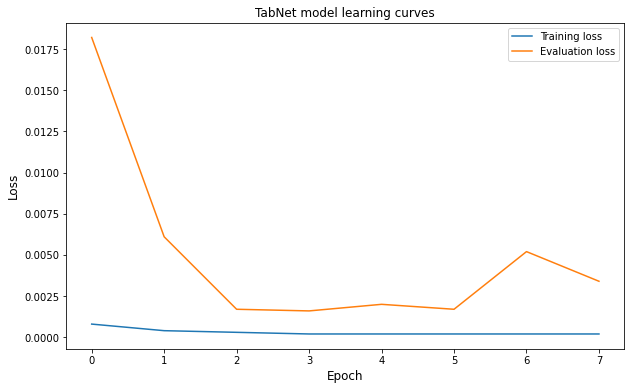

In [8]:
# Plot training and validation learning curves
plt.figure(figsize=(10,6))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('TabNet model learning curves')
plt.xticks(ticks=range(epochs))
plt.legend()
plt.show()

We will also visualize some random explanatory masks.

In [44]:
rand_mask_indices = np.random.randint(len(train_mask_explain_list[-1][0]), size=10)

expl_mask = train_mask_explain_list[-1][0][rand_mask_indices]
expl_mask = expl_mask.detach().numpy()

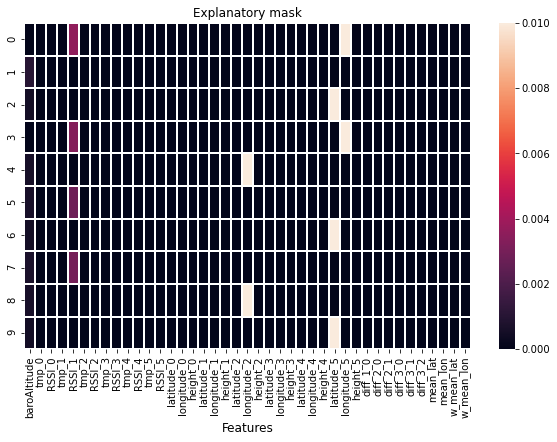

In [67]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(expl_mask, linewidths=1, vmin=0, vmax=0.01)
ax.set_xlabel('Features', size=12)
ax.set_title('Explanatory mask', size=12); 
ax.xaxis.set_ticklabels(norm_params['input_features'])
plt.show()

 Save the model's learned parameters for Inference

In [15]:
path = 'tabnet_params.pt'
torch.save(model.state_dict(), path)

We will save the user-defined TabNet parameters as well.

In [16]:
tabnet_user_params = {
    'input_dim': input_dim,
    'output_dim': output_dim,
    'n_d': n_d,
    'n_a': n_a,
    'gamma': gamma,
    'epsilon': epsilon,
    'n_shared': n_shared, 
    'n_independent': n_independent, 
    'n_steps': n_steps,
    'n_chunks': n_chunks,
    'chunk_size': chunk_size,
    'track_running_stats': track_running_stats,
    'momentum': momentum,
    'learning_rate': learning_rate,
    'feat_cols': feat_cols,
    'ghost_batch_norm': ghost_batch_norm
}

In [17]:
with open(r"tabnet_user_params.pickle", "wb") as output_file:
    pickle.dump(tabnet_user_params, output_file)

### References

[1]. <i>TabNet: Attentive Interpretable Tabular Learning</i>, Sercan O. Arık, Tomas Pfister, Google Cloud AI, https://arxiv.org/pdf/1908.07442.pdf